# Test - Geometric Brownian Motion Data

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
keras = tf.keras
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker

from dh_data import generate_GBM_data
from dh_framework import build_dh_model
from dh_loss_functions import VaR, CVaR, entropic
from dh_experiments import set_global_seed, BlackScholesPrice

# Set seed for reproducibility
set_global_seed(42)

/Users/rugile/Pricing and Hedging Using Neural Networks/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Generate GBM data
price_paths, payoffs = generate_GBM_data(
    N = 10**5,    # Number of samples to generate
    sigma = 0.2,  # Volatility
    d = 1,        # Number of assets 
    n = 100,      # Number of hedging steps
    K = 1.0,      # Strike of the option
    T = 1.0,      # Time-to-maturity
    S = 1.0       # Initial asset price
)

# Split data into training and testing data
xtrain, xtest, ytrain, ytest = train_test_split(
    price_paths, payoffs,
    test_size = 0.2,        # 20% of data is used for testing
    random_state = 42,
    shuffle = True
)

# Initialize lists
losses = ['mse', VaR(alpha=0.05), CVaR(alpha=0.05), entropic(beta = 3)]
titles = ['MSE', 'VaR', 'CVaR', 'Entropic']
histories = []
models = []
premiums = []
hedges = []
times = []
final_hedges = []

# Define the learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.005,
    decay_steps = 1000,
    decay_rate = 0.96,
    staircase = True
)

# Define an early stop
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

In [3]:
# Training Loop

for i, lossfn in enumerate(losses):
    keras.backend.clear_session()
    print(f"\nTraining model with {titles[i]} loss.")

    model, Network0, Networks = build_dh_model(
        d = 1,
        hidden_nodes = 32,
        L = 3,
        n = 100
    )

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
        loss = lossfn
    )

    start = tf.timestamp()          # Track training time
    history = model.fit(
        x=xtrain, y=ytrain,
        epochs = 50,
        batch_size = 1024,
        validation_split = 0.1,     # Use a validation set
        callbacks = early_stop,
        verbose = False
    )
    time = tf.timestamp() - start   # Total training time

    hedge = model.predict(xtest, verbose = 0)
    premium = float(Network0(tf.ones([1,1])).numpy().squeeze())
    final_hedge = Networks[-1](xtest[:, -2, 0:1]).numpy().flatten()

    models.append(model)
    premiums.append(premium)
    histories.append(history)
    hedges.append(hedge)
    times.append(float(time))
    final_hedges.append(final_hedge)


Training model with MSE loss.

Training model with VaR loss.

Training model with CVaR loss.

Training model with Entropic loss.


## View Results

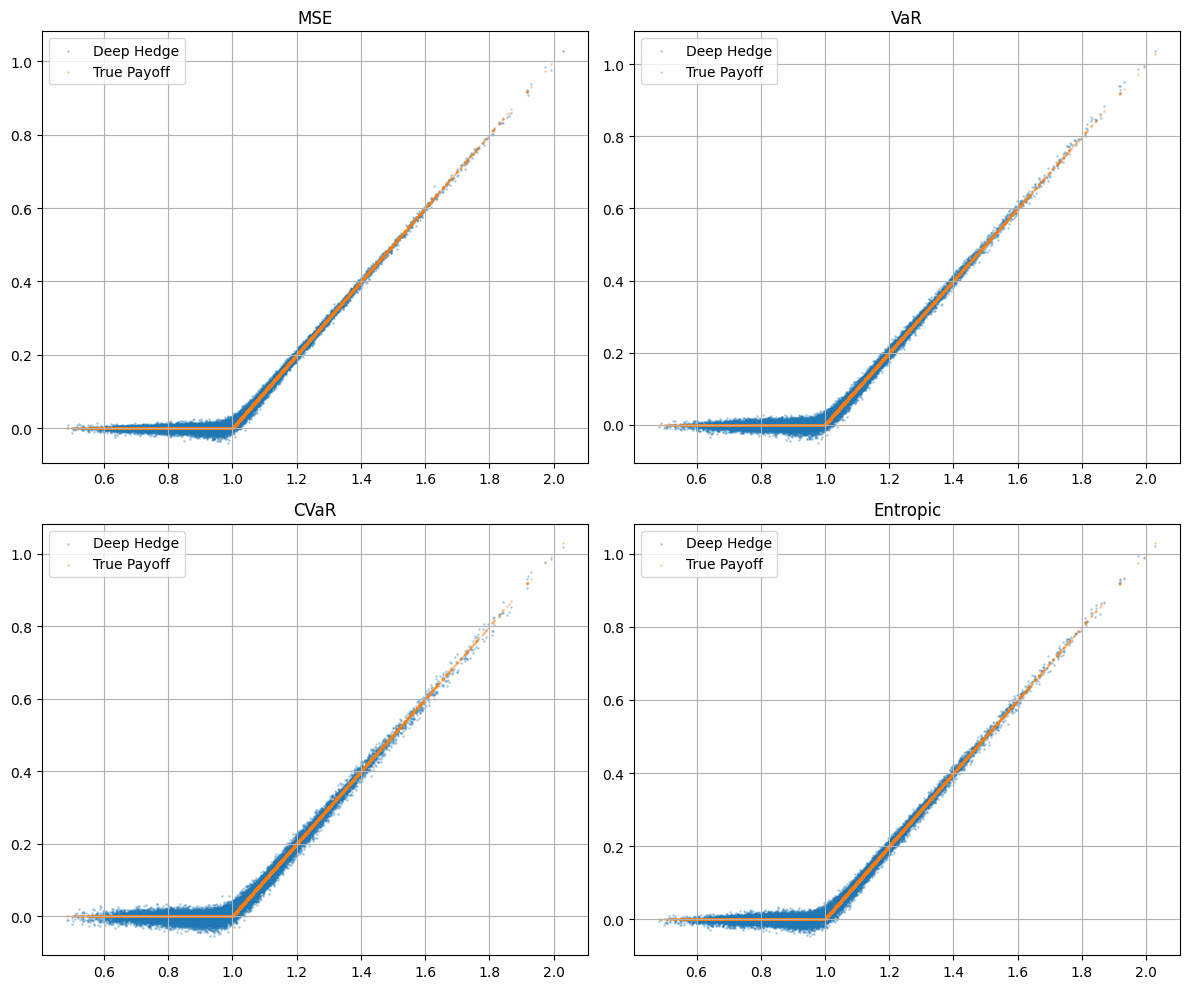


---- Model Premiums ----
MSE Premium: 0.07964585, with error 0.00038614
VaR Premium: 0.07945513, with error 0.00019542
CVaR Premium: 0.07826568, with error -0.00099403
Entropic Premium: 0.07961762, with error 0.00035791

---- Training Times ----
Training MSE took 182.07 seconds
Training VaR took 107.10 seconds
Training CVaR took 87.46 seconds
Training Entropic took 83.72 seconds


In [4]:
# Plot learned hedge v. payoff
fig, axes = plt.subplots(2,2,figsize = (12,10))

for i, ax in enumerate(axes.flat):
    ax.scatter(xtest[:,-1,0], hedges[i][:,0], s=1, alpha = 0.25, label = "Deep Hedge")
    ax.scatter(xtest[:,-1,0], ytest[:,0], s=1, alpha=0.25, label="True Payoff")
    ax.set_title(titles[i])
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

BSPremium = BlackScholesPrice(
    T=1.0,
    S=1.0,
    K=1.0,
    sigma=0.2
)
print("\n---- Model Premiums ----")
for name,premium in zip(titles,premiums):
    print(f"{name} Premium: {premium:.8f}, with error {premium-BSPremium:.8f}")

print("\n---- Training Times ----")
for name, time in zip(titles,times):
    print(f"Training {name} took {time:.2f} seconds")

## Plot Training vs. Validation Curves

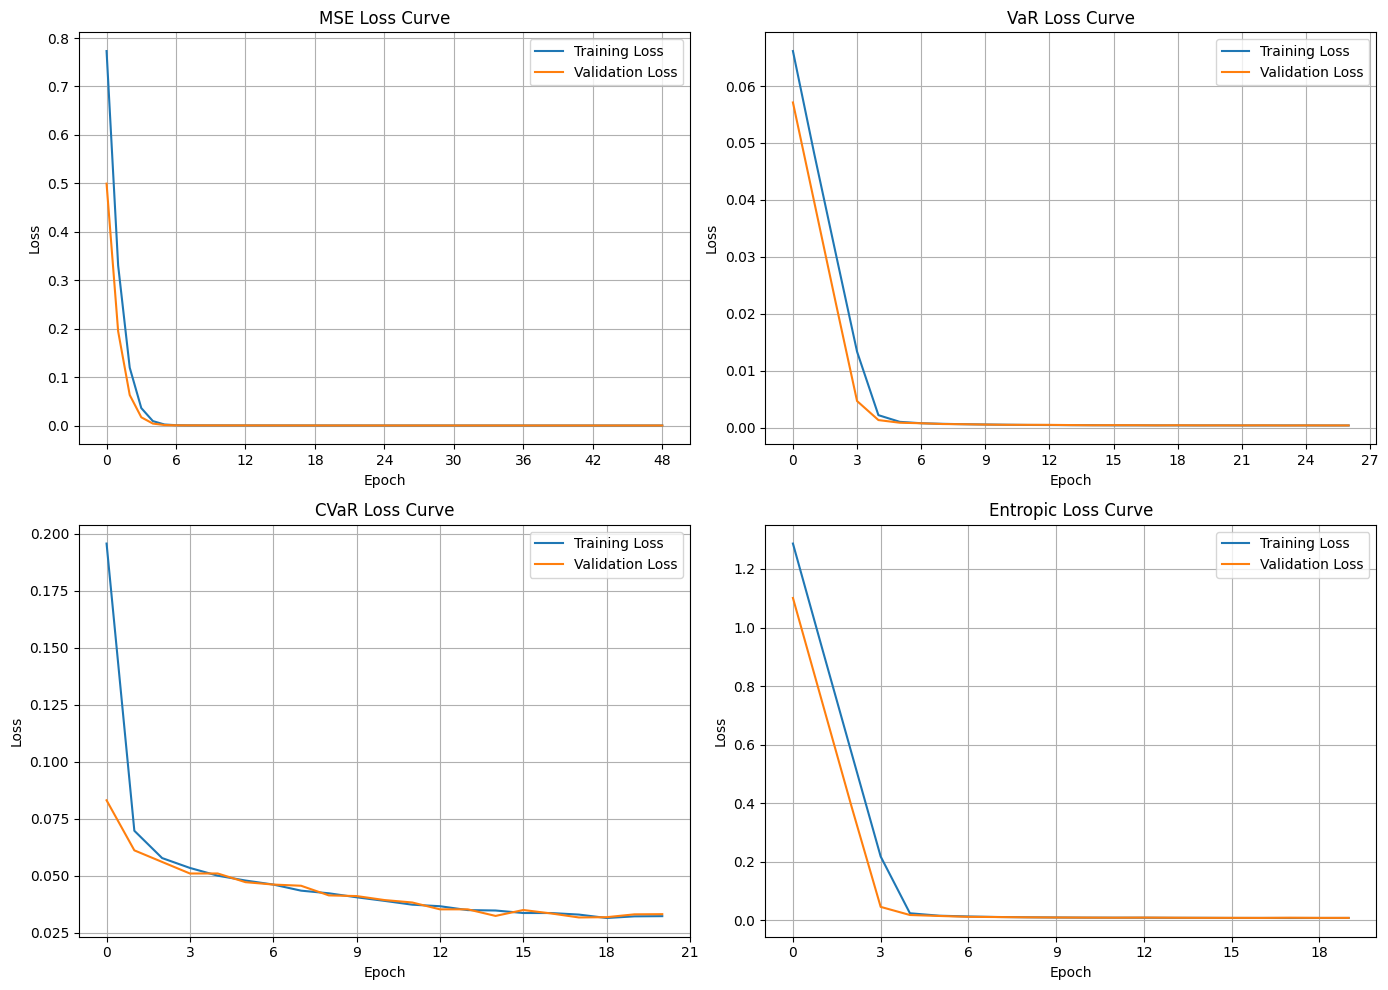

In [5]:
def plot_training_curves(histories, titles):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, history in enumerate(histories):
        ax = axes[i]
        ax.plot(history.history['loss'], label='Training Loss')
        ax.plot(history.history['val_loss'], label='Validation Loss')
        ax.set_title(f"{titles[i]} Loss Curve")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

plot_training_curves(histories, titles)

## Residual Error Statistics

In [6]:
def residual_error_statistics(predictions, labels, titles):
    print("\n--- Residual Error Statistics ---")
    for i, pred in enumerate(predictions):
        residuals = pred - labels
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        print(f"{titles[i]} - mean residual: {mean_res: .6f}, std: {std_res: .6f}")

residual_error_statistics(hedges, ytest, titles)


--- Residual Error Statistics ---
MSE - mean residual: -0.000032, std:  0.008013
VaR - mean residual: -0.000291, std:  0.009880
CVaR - mean residual: -0.001497, std:  0.012988
Entropic - mean residual: -0.000122, std:  0.010160


## Final Hedging Strategy vs Classical Delta

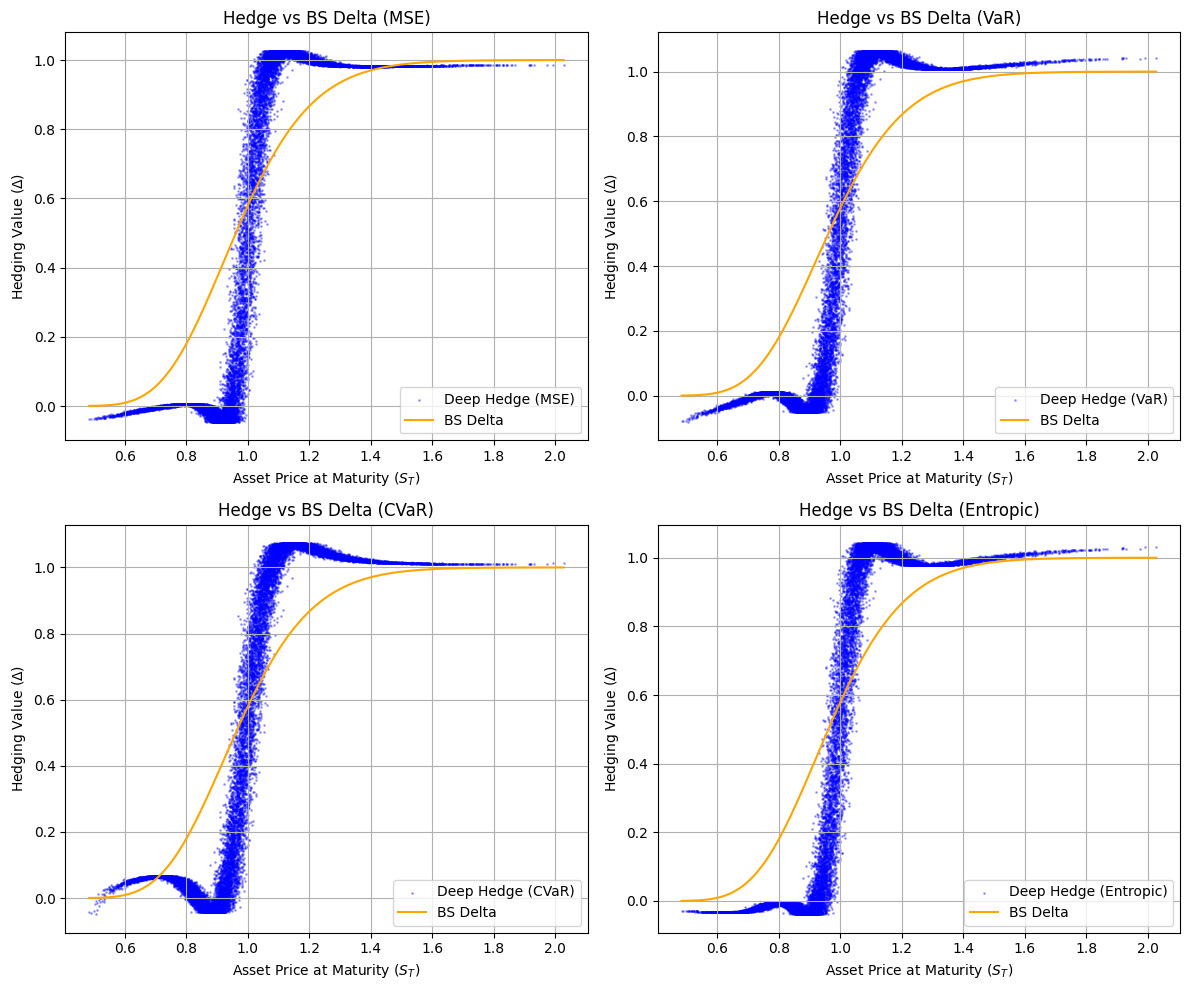

In [7]:
S_T = xtest[:, -1, 0]

bs_deltas = np.array([
    BlackScholesPrice(T=1.0, S=s, K=1.0, sigma=0.2, greeks=True)['delta']
    for s in S_T
])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(S_T, final_hedges[i], s=1, alpha=0.3, color='blue', label=f'Deep Hedge ({titles[i]})')
    ax.plot(np.sort(S_T), np.sort(bs_deltas), color='orange', label='BS Delta')
    ax.set_title(f"Hedge vs BS Delta ({titles[i]})")
    ax.set_xlabel("Asset Price at Maturity ($S_T$)")
    ax.set_ylabel("Hedging Value ($\\Delta$)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

# RMSE
print("\n--- Hedge RMSE vs Black-Scholes Delta ---")
for i, title in enumerate(titles):
    mse = mean_squared_error(bs_deltas, final_hedges[i])
    rmse = np.sqrt(mse)
    print(f"{title:<10} RMSE: {rmse:.6f}")

# Correlation of hedge vs. BS Delta
print("\n--- Correlation with BS Delta ---")
for i, title in enumerate(titles):
    corr = np.corrcoef(final_hedges[i], bs_deltas)[0, 1]
    print(f"{title:<10} Corr: {corr:.6f}")


--- Hedge RMSE vs Black-Scholes Delta ---
MSE        RMSE: 0.256401
VaR        RMSE: 0.256214
CVaR       RMSE: 0.241644
Entropic   RMSE: 0.247094

--- Correlation with BS Delta ---
MSE        Corr: 0.899480
VaR        Corr: 0.908690
CVaR       Corr: 0.906275
Entropic   Corr: 0.912347
